# Sentiment 
Code adapted from How to Make a Racist AI Without Even Knowing
http://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/

In [2]:
import numpy as np
import pandas as pd
import re
import statsmodels.formula.api

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /home/arnoldyb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# DO THIS ONLY ONCE
# Downloads and unpacks the GloVe embeddings 
#!wget -c http://nlp.stanford.edu/data/glove.42B.300d.zip

--2019-07-17 04:26:50--  http://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.42B.300d.zip [following]
--2019-07-17 04:26:50--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2019-07-17 04:26:50--  http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]
Sav

In [4]:
# DO THIS ONLY ONCE
# unzip the file
# if you don't have unzip installed, run: !sudo apt-get install unzip
#!mkdir -p data/sent/
#!unzip glove.42B.300d.zip -d data/sent/

Archive:  glove.42B.300d.zip
replace data/sent/glove.42B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [7]:
def load_embeddings(filename):
    """
    Load a DataFrame from pretrained embeddings. 
    For this, we are going to use GloVe.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    return pd.DataFrame(np.vstack(rows), index=labels, dtype='f')

embeddings = load_embeddings('./data/sent/glove.42B.300d.txt')
embeddings.shape

(1917494, 300)

In [ ]:
# DO THIS ONLY ONCE
#!wget http://www.cs.uic.edu/~liub/FBS/opinion-lexicon-English.rar

In [ ]:
# DO THIS ONLY ONCE
# if you don't have unrar installed, run commented out line
#!sudo apt-get install unrar
#!unrar x opinion-lexicon-English.rar -d data/sent/

In [8]:
def load_lexicon(filename):
    """
    Load a file from Bing Liu's sentiment lexicon
    (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), containing
    English words in Latin-1 encoding.
    
    One file contains a list of positive words, and the other contains
    a list of negative words. The files contain comment lines starting
    with ';' and blank lines, which should be skipped.
    """
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

pos_words = load_lexicon('data/sent/opinion-lexicon-English/positive-words.txt')
neg_words = load_lexicon('data/sent/opinion-lexicon-English/negative-words.txt')

In [9]:
pos_vectors = embeddings.loc[pos_words].dropna()
neg_vectors = embeddings.loc[neg_words].dropna()

/home/arnoldyb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/arnoldyb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


In [10]:
vectors = pd.concat([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
labels = list(pos_vectors.index) + list(neg_vectors.index)

In [11]:
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
    train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

In [12]:
model = SGDClassifier(loss='log', random_state=0, n_iter=100)
model.fit(train_vectors, train_targets)

/home/arnoldyb/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=100,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [13]:
accuracy_score(model.predict(test_vectors), test_targets)

0.9502262443438914

In [14]:
def vecs_to_sentiment(vecs):
    # predict_log_proba gives the log probability for each class
    predictions = model.predict_log_proba(vecs)
    # To see an overall positive vs. negative classification in one number,
    # we take the log probability of positive sentiment minus the log
    # probability of negative sentiment.
    return predictions[:, 1] - predictions[:, 0]


def words_to_sentiment(words):
    vecs = embeddings.loc[words].dropna()
    log_odds = vecs_to_sentiment(vecs)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)

# Show 20 examples from the test set
words_to_sentiment(test_labels).ix[:20]

/home/arnoldyb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()


,sentiment
fidget,-9.931679
interrupt,-9.634706
staunchly,1.466919
imaginary,-2.989215
taxing,0.468522
world-famous,6.908561
low-cost,9.237223
disapointment,-8.737182
totalitarian,-10.851580
bellicose,-8.328674


In [15]:
def text_to_sentiment(text):
    tokens = word_tokenize(text.lower())
    try: 
        sentiments = words_to_sentiment(tokens)
    except: # handle case where there's no known words in input
        return 0
    return sentiments['sentiment'].mean()

In [ ]:
text_to_sentiment("except you all")

In [16]:
import os
import csv
from NYT_parser import NYTArticle
from utilities import *

article = NYTArticle.from_file('../data/1995/01/25/0739212.xml')


In [ ]:
article.title

In [ ]:
text_to_sentiment(article.title)

In [ ]:
article.paragraphs

In [17]:
def score_article(text):
    score = 0
    num_sentences = 0
    for sentence in text:
        num_sentences += 1
        score += text_to_sentiment(sentence)
    if num_sentences == 0:
        return 0
    else:
        return score / num_sentences

In [21]:
print("The score of this article is", score_article(article.paragraphs))

The score of this article is 1.0086962283673448


In [19]:
import warnings
warnings.filterwarnings('ignore')

headline_sent = list()
body_sent = list()
lede_sent = list()

# go through a few examples
start_article = 1843976
end_article = 1844129 # last possible is 1213168

for article_num in range(start_article,end_article):
    article = NYTArticle.from_file('../data/2007/04/30/'+str(article_num)+'.xml')
    print("File ID",article.docid)
    print("Headline:",article.title)
    headline_sent.append(text_to_sentiment(article.title))
    body_sent.append(score_article(article.paragraphs))
    lede_sent.append(score_article(article.lede))
    print("Headline sentiment",headline_sent[-1])
    print("Body sentiment",body_sent[-1])
    print("Lede sentiment",lede_sent[-1])
    print("=====================================")
    
scoreDF = pd.DataFrame({'Head_Sent': headline_sent, 'Body_Sent': body_sent, 'Lede_Sent': lede_sent})

File ID 1843976
Headline: Paid Notice: Deaths   BALL, DR. EUGENE R.
Headline sentiment -1.783655229651751
Body sentiment 1.3413911142107382
Lede sentiment 1.3413911142107382
File ID 1843977
Headline: Paid Notice: Deaths   COHEN, LINDA KAY
Headline sentiment -0.5926860477666003
Body sentiment 1.778941778643431
Lede sentiment 1.778941778643431
File ID 1843978
Headline: Paid Notice: Deaths   ELIAS, WERNER K.
Headline sentiment -1.673959657801518
Body sentiment 0.9279617040950495
Lede sentiment 0.9279617040950495
File ID 1843979
Headline: Paid Notice: Deaths   GARY, RAYMOND BEDROS
Headline sentiment -1.2702769912566543
Body sentiment 1.2701193764435066
Lede sentiment 1.2701193764435066
File ID 1843980
Headline: Paid Notice: Deaths   HALBERSTAM, DAVID
Headline sentiment -1.6623230407469702
Body sentiment 2.045991075118646
Lede sentiment 2.045991075118646
File ID 1843981
Headline: Paid Notice: Deaths   HAUSMANN, ROSALIE L.
Headline sentiment -2.7048528061699635
Body sentiment -0.009253741153

Headline sentiment -0.3669923572995473
Body sentiment 1.3782270758159714
Lede sentiment 1.3953678958226226
File ID 1844015
Headline: Pas de Trois: Boiling Down Tolstoy's Tale For Ballet
Headline sentiment 1.4928050906987875
Body sentiment 2.0144082209046084
Lede sentiment 1.7801194318042417
File ID 1844016
Headline: As Blogs Proliferate, a Gadfly With Accreditation at the U.N.
Headline sentiment 0.9300600037194121
Body sentiment 1.4143793189663956
Lede sentiment 1.0569827649725263
File ID 1844017
Headline: Phone Taps In Italy Spur Rush Toward Encryption
Headline sentiment 1.022660464995406
Body sentiment 1.5356918342044372
Lede sentiment 1.583597549001155
File ID 1844018
Headline: Garden & Gun Magazine Has an Awkward Debut
Headline sentiment 1.540823685440139
Body sentiment 1.2831160645290376
Lede sentiment 1.6072103181098922
File ID 1844019
Headline: Bloggers Cast Doubt on Fox's Generosity
Headline sentiment 3.5138631126335653
Body sentiment 1.5851831179520368
Lede sentiment 1.1677709

Headline sentiment -1.5616444426819527
Body sentiment 1.4599539475021621
Lede sentiment 0.7613720428647737
File ID 1844054
Headline: Georgia's Shame
Headline sentiment -0.8976969459610148
Body sentiment 1.2888547174469773
Lede sentiment 0.19786490670321366
File ID 1844055
Headline: Bundling in the Capitol
Headline sentiment 1.415864736590283
Body sentiment 1.3931331551420045
Lede sentiment 0.8967919051067269
File ID 1844056
Headline: Bloomberg's Green Vision
Headline sentiment 5.440151645443926
Body sentiment 1.99636683972439
Lede sentiment 1.33604506774667
File ID 1844057
Headline: Truth in Co-ops: Just Tell Me Why I'm Not In
Headline sentiment -0.2780066702871676
Body sentiment 0.7620565019929253
Lede sentiment 0.47683594063085
File ID 1844058
Headline: A Push to Legalize Gay Marriage
Headline sentiment 1.6287787744642552
Body sentiment 1.3297042387051337
Lede sentiment 0.5211225338414065
File ID 1844059
Headline: India's Economic Progress
Headline sentiment 4.39935917262942
Body sen

Headline sentiment 4.736770621396051
Body sentiment 1.5473842184599789
Lede sentiment 0.8509777421603912
File ID 1844094
Headline: That Elusive Race On the First Saturday in May
Headline sentiment -0.4036169502686477
Body sentiment 1.1812699408858907
Lede sentiment 1.6262519099165837
File ID 1844095
Headline: Rozsival Saves Rangers With His Eyes Closed
Headline sentiment -0.07567888113386381
Body sentiment 0.7124615068906311
Lede sentiment 0.6031943419148394
File ID 1844096
Headline: Critic's Choice: New CDs
Headline sentiment 1.9043435596770086
Body sentiment 0.6334044886820346
Lede sentiment 0.21451210594192854
File ID 1844097
Headline: Critic's Choice: New CDs
Headline sentiment 1.9043435596770086
Body sentiment 0.3748753590330639
Lede sentiment 0.3096033922357635
File ID 1844098
Headline: Critic's Choice: New CDs
Headline sentiment 1.9043435596770086
Body sentiment 1.5735898239426227
Lede sentiment 1.7717406403705076
File ID 1844099
Headline: Critic's Choice: New CDs
Headline senti

In [22]:
scoreDF.describe()

,Head_Sent,Body_Sent,Lede_Sent
count,153.000000,153.000000,153.000000
mean,0.469101,1.125800,1.038635
std,2.196575,0.675373,0.817048
min,-4.922583,-0.596693,-1.816096
25%,-0.897697,0.704632,0.483894
50%,0.778198,1.121430,0.959334
75%,1.964201,1.517883,1.582708
max,5.440152,2.729601,3.182002


(array([ 2., 12., 12., 13., 26., 26., 32., 19.,  9.,  2.]),
 array([-4.92258328, -3.88630978, -2.85003629, -1.8137628 , -0.77748931,
         0.25878419,  1.29505768,  2.33133117,  3.36760466,  4.40387815,
         5.44015165]),
 <a list of 10 Patch objects>)

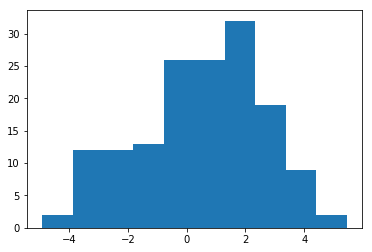

In [26]:
import matplotlib.pyplot as plt
plt.hist(scoreDF['Head_Sent'])

(array([ 2.,  7., 12., 21., 33., 34., 14., 12., 14.,  4.]),
 array([-0.5966929 , -0.26406356,  0.06856579,  0.40119513,  0.73382447,
         1.06645382,  1.39908316,  1.7317125 ,  2.06434185,  2.39697119,
         2.72960053]),
 <a list of 10 Patch objects>)

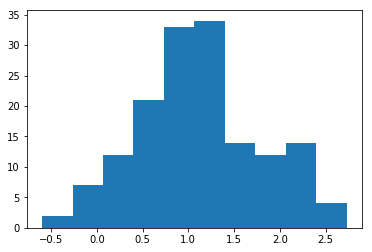

In [24]:
import matplotlib.pyplot as plt
plt.hist(scoreDF['Body_Sent'])

(array([ 1.,  1.,  3., 18., 25., 40., 32., 21.,  8.,  4.]),
 array([-1.8160957 , -1.3162859 , -0.8164761 , -0.3166663 ,  0.18314351,
         0.68295331,  1.18276311,  1.68257291,  2.18238271,  2.68219251,
         3.18200231]),
 <a list of 10 Patch objects>)

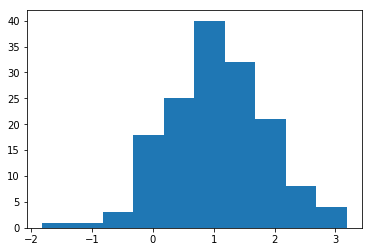

In [25]:
import matplotlib.pyplot as plt
plt.hist(scoreDF['Lede_Sent'])

In [27]:
# neg headline, positive lede
# basically, the score for the headline is weird -- should be positive
article_num = 1844014
article = NYTArticle.from_file('../data/2007/04/30/'+str(article_num)+'.xml')
print("Headline:",article.title)
print(article.paragraphs)


Headline: A Little Bit Of Country Infuses A Pop Instinct
["''We're about to get country on you,'' Brandi Carlile said on Friday night, during the encore portion of her second sold-out Bowery Ballroom show. She was speaking some truth -- the next song was Johnny Cash's ''Folsom Prison Blues'' -- but the warning came belatedly. Ms. Carlile and her band had just wrapped up a long set suffused with country feeling, though it wasn't always patently clear.", 'Ms. Carlile, who hails from the outskirts of Seattle, has the kind of voice most Nashville producers would be happy to work with: roomy, dark-hued and bittersweet, with a firmness of purpose and pitch.', 'She favors one of the classic country-singer devices, an accented break between upper and lower ranges. At times she scoops dramatically up to a note, like a slide guitarist. And in the harmonies she strikes with her creative partners, the twins Tim and Phil Hanseroth, there are hints of bluegrass and Grand Ole Opry twang.', "For ''The

In [29]:
# neg headline, pos lede
# I have no idea how the lede got a positive classification; it shouldn't
article_num = 1844009
article = NYTArticle.from_file('../data/2007/04/30/'+str(article_num)+'.xml')
print("Headline:",article.title)
print(article.paragraphs)

Headline: After Virginia Tech, Testing Limits of Movie Violence
["If the horror at Virginia Tech has changed the chemistry of America's popular culture, those who count box-office receipts at Lionsgate would be among the first to know.", "The independent studio, a clearinghouse for some of the entertainment industry's most graphically violent fare, still plans to release on June 8 its ''Hostel: Part II,'' about the torture killing of college students.", "The movie will open as other studios are turning toward comedies like ''Knocked Up,'' capers like ''Ocean's 13,'' or fantasy adventures like ''Fantastic Four: Rise of the Silver Surfer.''", "Given its subject matter and the marketing campaign that has already come with it -- posters featuring a woman's severed head and other grisly images are now scattered on the Web -- the Lionsgate film is emerging as a test of continued audience enthusiasm for such onscreen brutality, which some commentators have connected with the Blacksburg gunman

In [40]:
# neg headline, pos lede and body
# actually, this one is interesting because the content is certainly negative -- it's about a rape.
# but it is written kind of as a curious science story
# this is a case where maybe the positive sentiment would more accurately describe the kind of "think" piece this is, tho
# a more accurate headline in this case might jar readers a bit given the violence at its heart
article_num = 1844101
article = NYTArticle.from_file('../data/2007/04/30/'+str(article_num)+'.xml')
print("Headline:",article.title)
print(article.paragraphs)

Headline: Disease Drove Sex Attack, Defense Says
["He was a media columnist for Women's Wear Daily who built a reputation on his writing about the counterculture of the 1960s and '70s. He got attention for his odd dress, a self-consciously nerdy, retro look that reminded some people of Austin Powers. His prose was dense, sarcastic, with intellectual overtones.", 'Now the writer, Peter Braunstein, 43, is about to go on trial, charged with a bizarre crime against a woman who worked in his own newsroom. Prosecutors say he dressed as a firefighter, staged a fire to get into her Chelsea apartment, tied her to a bed, drugged her with chloroform and sexually molested her for 13 hours.', 'As the trial opens today in State Supreme Court in Manhattan, jurors will be asked to decide whether he was a sadistic man preying on an unsuspecting woman or whether his actions were the result of mental illness.', "The defense has conceded that he committed the crime, and is working on a risky defense that 

In [31]:
# neg headline, pos lede
# i would say that the headline is misclassified because it doesn't recognize negation "no ill" but... the story is actually
# kind of negative
article_num = 1844028
article = NYTArticle.from_file('../data/2007/04/30/'+str(article_num)+'.xml')
print("Headline:",article.title)
print(article.paragraphs)

Headline: No Ill Feelings: Producers Bet on a 'Superwoman'
['Donna Murphy is feeling fine.', "She's a few days from opening in the Manhattan Theater Company's production of ''LoveMusik,'' the Hal Prince-directed musical about the 25-year romance between Kurt Weill and Lotte Lenya, and she's out there every night, crooning ''Speak Low'' with her co-star, Michael Cerveris, and belting out ''Surabaya Johnny'' in her meticulously researched Lotte Lenyese accent.", 'No, nothing is bothering Ms. Murphy.', "Well, there is that malady that she has been trying to shake for the last several years, a little condition that Broadway wags refer to as the ''Donna Murphy syndrome.''", 'Strictly speaking, it means a tendency to miss a lot of performances; more broadly, it is all the gossip and sniping that has been directed at Ms. Murphy, who also happens to be one of the most ecstatically reviewed musical actresses around.', "Not that long ago the gossip around Broadway was that Donna Murphy the star 

In [32]:
# both headline and lede neg; positive body
# one observation --- international news seems to have a lot more negative headlines and more likely to also
# be classified with a negative lede. 2007 was a rough year for international news and the style is more hard news, 
# stark, and less flowery and featurey generally. This is the type of story that might improve most w/ sentiment added.

article_num = 1844037
article = NYTArticle.from_file('../data/2007/04/30/'+str(article_num)+'.xml')
print("Headline:",article.title)
print(article.paragraphs)


Headline: In Turkey, Fear and Discomfort About Religious Lifestyle
['When hundreds of thousands of protesters filled the streets of Istanbul on Sunday, it may have looked like a protest of government policy.', 'It was not.', 'Behind the slogans and signs of marchers in Istanbul on Sunday and in Ankara two weeks ago was something much more basic: a fear of the lifestyles of their more religious compatriots.', 'Some concerns were snobbish: religious Turks were uneducated and poor, their pesky prayer rugs got underfoot in hospital halls.', 'Others were less elitist and had more personal worries: how much tolerance for our secular lifestyles will an emerging class of religious Turks have?', "''These people are from poor areas; they just don't know what the government stands for,'' said Aysel Tuikman, 39, a civil servant wearing a skirt, a sweater, beige pumps and pearls. ''They're only being manipulated. We are here for their good also.''", "''People here are the real Turkey,'' she said, w

In [33]:
# both headline and lede neg; positive body
# here you can see why ledes are probably better to focus on. the lede conveys the negative news that will also carry the headline.
# the body offers a bunch of background context that winds up washing out the negative score for the text
article_num = 1844038
article = NYTArticle.from_file('../data/2007/04/30/'+str(article_num)+'.xml')
print("Headline:",article.title)
print(article.paragraphs)

Headline: U.S. Clashes With Militia In Baghdad
['Militiamen loyal to the Shiite cleric Moktada al-Sadr clashed with American forces in northern Baghdad on Sunday, an Interior Ministry official said, the latest in a series of indications that the militia might be emerging from two months of self-imposed dormancy.', 'On the orders of Mr. Sadr, the militia, known as the Mahdi Army, has remained largely underground since the intensified security plan for Baghdad took effect in mid-February. But a steady increase in the number of corpses recovered from the streets in recent weeks, and sporadic clashes between Mahdi fighters and government forces, have suggested a possible resurgence of the militia.', 'Its return could significantly complicate the American-led effort to tame violence in the capital because it would split the attention of American and Iraqi forces, already struggling to subdue the Sunni Arab insurgency and interrupt its campaign of vehicle bombings against Shiite targets.', '

In [34]:
# both headline and body neg but lede barely positive
# I am really surprised the lede is scored negative
article_num = 1844040
article = NYTArticle.from_file('../data/2007/04/30/'+str(article_num)+'.xml')
print("Headline:",article.title)
print(article.paragraphs)

Headline: Afghans Protest After Coalition Raid Kills 6 People
['A raid by American and Afghan troops on a suspected bomb-making compound before dawn on Sunday killed six people, including two women, and wounded two children in eastern Afghanistan, Afghan officials said.', "Hundreds of angry villagers brought the bodies of the victims onto the main Kabul-to-Pakistan highway nearby and demonstrated for more than five hours, chanting ''Death to America,'' the Afghan police said.", "Col. Ghafoor Khan, spokesman for the police chief in Nangarhar Province, where the raid occurred, said that the people who were killed or wounded were all civilians. ''Six civilians, including two women, were killed in this incident, and eight others were detained by coalition forces,'' he said in a telephone interview.", 'But the United States military, while it confirmed the raid and the death toll, said in a statement that four of the dead were militants, and that a teenage girl and a younger girl were wound

In [35]:
# both headline and lede neg; body positive
# again, lede is more focused, rest of article is more contextual and neutral. should focus on lede
article_num = 1844043
article = NYTArticle.from_file('../data/2007/04/30/'+str(article_num)+'.xml')
print("Headline:",article.title)
print(article.paragraphs)

Headline: Rice Rebuts Tenet's Assertion That '01 Warning Was Ignored
['Secretary of State Condoleezza Rice defended herself on Sunday against the assertion by the former C.I.A. director, George J. Tenet, that she had dismissed his warnings in July 2001 of possible terrorist attacks by Al Qaeda.', "In his new book, ''At the Center of the Storm,'' to be published on Monday, Mr. Tenet wrote that there had been no ''serious debate'' within the Bush administration about whether Iraq posed an imminent threat or on how a long American military presence in Iraq might play out; and that his early efforts to warn Ms. Rice and others of Al Qaeda's threats were treated too lightly.", "Ms. Rice, who appeared on several Sunday television talk shows, said on the CBS News program ''Face the Nation'' that the administration had tried many ways to deal with Iraq, over ''an extended period of time,'' including efforts to tighten international sanctions.", "In an excerpt from a taped CBS interview, broadc

In [36]:
# both headline and lede neg; body positive
# weird case of name of team -- Devils -- biasing the score of the headline
article_num = 1844045
article = NYTArticle.from_file('../data/2007/04/30/'+str(article_num)+'.xml')
print("Headline:",article.title)
print(article.paragraphs)

Headline: Playoff Experience Is on Devils' Side
['Travis Zajac, a 21-year-old rookie center for the Devils, retreated with his teammates to the locker room after the third period Saturday night. He was not quite sure what to expect when the door was closed.', 'The Devils had lost a lead to the Ottawa Senators with 27 seconds left in regulation, extending the game into overtime, and Devils right wing Brian Gionta had been called for a hooking penalty at the end of regulation.', 'Zajac, who was playing for the University of North Dakota in the N.C.A.A. Frozen Four last April, said he was somewhat agitated, especially because his line had wasted so many chances. The interesting part, however, was that no one else was agitated.', "''It's experience,'' Zajac said. ''They know that something like that goal is not getting to us.''", 'Early in the second overtime period, Zajac chipped the puck to Jamie Langenbrunner, the right wing on his line, and Langenbrunner beat Senators goaltender Ray Em

In [37]:
# headline negative, body and lede neg
# funny -- all three are basically misclassified. this is a positive toned story.
article_num = 1844053
article = NYTArticle.from_file('../data/2007/04/30/'+str(article_num)+'.xml')
print("Headline:",article.title)
print(article.paragraphs)

Headline: Who's Afraid of Pay-Go?
['There is rare good news from the otherwise grim budget front. Majorities in both the House and Senate have voted to impose a pay-as-you-go rule, starting with the 2008 federal budget, which they plan to complete this spring.', "''Pay-go,'' which was abandoned in 2002, is vital to restoring budget discipline. It would require Congress to pay for new spending on entitlements, like Medicare, either by raising taxes or cutting other entitlements. It would also require legislators to make up forgone revenue from new tax cuts by raising other taxes or cutting spending.", "There are differences, however, in the chambers' approaches to pay-go. The House's approach is better because it has no tricky escape hatches. In contrast, the Senate's version of the budget contains an amendment that would make it all too easy to sidestep the rule. For example, 60 senators would be able to pass a bill today to extend Bush-era tax cuts set to expire in 2010, claiming that

In [38]:
# headline negative, body and lede pos
article_num = 1844057
article = NYTArticle.from_file('../data/2007/04/30/'+str(article_num)+'.xml')
print("Headline:",article.title)
print(article.paragraphs)

Headline: Truth in Co-ops: Just Tell Me Why I'm Not In
['To the Editor:', "Re ''Pushing Co-ops to Explain Why You Can't Buy'' (front page, April 21):", 'My own experience as a former co-op board president is in direct contrast to the rhetoric of the co-op industry representatives opposing a bill requiring co-op boards to explain why they have rejected an applicant.', "The board I served on tried hard to make decisions on the merits. It would have been easy for us to put in writing why we made decisions about sales, since we always knew what motivated our actions. That's undoubtedly the case at most co-ops.", "Would this bill discourage anyone from joining a co-op board, as industry spokesmen have argued? Don't believe it for a second. Instead, it will simply provide a strong incentive for co-ops to adopt a ''best practices'' standard toward purchases, with fair and open decision-making. Anyone who cannot abide by this simple goal should not be on a co-op board in the first place.", 'Jo

In [39]:
# headline negative, body and lede pos
article_num = 1844062
article = NYTArticle.from_file('../data/2007/04/30/'+str(article_num)+'.xml')
print("Headline:",article.title)
print(article.paragraphs)


Headline: Arrested at a Protest
['To the Editor:', "Re ''At the Protest, a Civics Lesson Gets a Twist,'' by Jim Dwyer (About New York column, April 25):", 'As one of the 1,806 people who were arrested during protests at the Republican convention in New York in 2004, I agree that the mass arrests offered a grim civics lesson.', 'I am a columnist for The Athens Banner-Herald, the daily newspaper here. While taking notes and photographs at a peaceful demonstration outside the New York Public Library, I and scores of others were ensnared by New York police officers using nets to corral both protesters and bystanders.', "I considered my arrest and 30 hours in jail to be both a badge of honor and an occupational hazard. I also consider the New York authorities' tactic of mass arrests just a pretext for crushing dissent and silencing antiwar voices during convention week.", 'Such a roughshod trampling of civil liberties should never again be allowed to happen on the streets of New York or any

## Some thoughts
After doing a quick and dirty EDA on the sentiment applied to one day's worth of articles, I'm a little worried. Most articles do not get scored overall negative. The one that did was actually a cute sort of article about a decision not to prosecute someone for throwing a baseball back onto a field (see cell above). 
Possible improvements:
* we could apply sentiment to just the lede
* we could set ranges for body text sentiment -- anything below the mean is "negative" even if most of the overall values are positive
* we could try a more nuanced sentiment classifier - one that has a range of emotions like happy, angry, etc. rather than positive/negative

